# CATRA experiments and analysis

### Common imports

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set(font_scale=1.5)
import experiments
from experiments import Status

In [2]:
! cat results/catra-0.1.4-5.experiments.batch_{0..7}.log results/catra-0.1.4-5.experiments.batch_missing.log > master-results.log

### Constants

In [3]:
commit = "5810e6d"
logfile = f"master-results.log"
TIMEOUT_S = 30 # FIXME read from log

##  Instances solved
How many instances can we solve, in general?

In [4]:
runtimes = experiments.log2df(logfile)

An issue with the experiment setup led us to re-run some benchmarks using the default catra front-end: they are included here:

In [5]:
extra_runtimes = pd.concat([experiments.parse_catra_log(
    f"results/catra-0.1.4-5.experiments.batch_missing2_{backend}.log", backend)
                  for backend in ["baseline", "lazy", "nuxmv"]])

...and dropped by deduplication here:

In [6]:
runtimes = pd.concat([runtimes, extra_runtimes]).drop_duplicates(subset=["instance", "backend"],
                                                                 keep="last")

In [7]:
best_status = runtimes.groupby('instance').status.min()

How many instances for the respective backends?

In [8]:
runtimes.groupby(['backend']).size()

backend
baseline    37497
lazy        37497
nuxmv       37497
dtype: int64

In [9]:
NR_INSTANCES = runtimes.instance.unique().size
NR_INSTANCES

37497

In [10]:
timeout_instances = best_status[best_status == Status.TIMEOUT].reset_index().instance
#runtimes = runtimes[~runtimes['instance'].isin(timeout_instances)]

How many instances had all solvers time out?

In [11]:
timeout_instances.size

16659

In [12]:
#results_per_instance = runtimes.groupby('instance').size()
#tried_on_all = results_per_instance[results_per_instance == runtimes.backend.cat.categories.size ].reset_index().instance
# runtimes = runtimes[runtimes['instance'].isin(tried_on_all)]

## Correctness check

In [13]:
success_runs = runtimes[runtimes['status'] < Status.TIMEOUT]
success_runs_by_instance = success_runs.groupby(['instance'])

nr_statuses = success_runs_by_instance.status.nunique().reset_index()
nr_statuses[nr_statuses['status'] != 1]

,instance,status


It's empty so they all concur!

In [14]:
success_runs.groupby(['instance', 'status']).size()

instance                                     status           
../../../amanda/deduped-benchmarks/100.par   Status.SAT           1
                                             Status.UNSAT         0
                                             Status.TIMEOUT       0
                                             Status.MEMORY_OUT    0
                                             Status.ERROR         0
                                                                 ..
../../../amanda/deduped-benchmarks/9997.par  Status.SAT           2
                                             Status.UNSAT         0
                                             Status.TIMEOUT       0
                                             Status.MEMORY_OUT    0
                                             Status.ERROR         0
Length: 104190, dtype: int64

### Errors

In [15]:
runtimes[runtimes['status'] > Status.TIMEOUT]

,backend,instance,status,runtime
61343,nuxmv,../../../amanda/deduped-benchmarks/36399.par,Status.ERROR,inf
61439,nuxmv,../../../amanda/deduped-benchmarks/36423.par,Status.ERROR,inf
61445,nuxmv,../../../amanda/deduped-benchmarks/36379.par,Status.ERROR,inf
61502,nuxmv,../../../amanda/deduped-benchmarks/37210.par,Status.ERROR,inf
61637,nuxmv,../../../amanda/deduped-benchmarks/36363.par,Status.ERROR,inf
73697,nuxmv,../../../amanda/deduped-benchmarks/36417.par,Status.ERROR,inf
73817,nuxmv,../../../amanda/deduped-benchmarks/36411.par,Status.ERROR,inf
74123,nuxmv,../../../amanda/deduped-benchmarks/36412.par,Status.ERROR,inf
74174,nuxmv,../../../amanda/deduped-benchmarks/36422.par,Status.ERROR,inf
101323,lazy,../../../amanda/deduped-benchmarks/5922.par,Status.ERROR,inf


## Outcomes

How many instances are in each category, per backend?

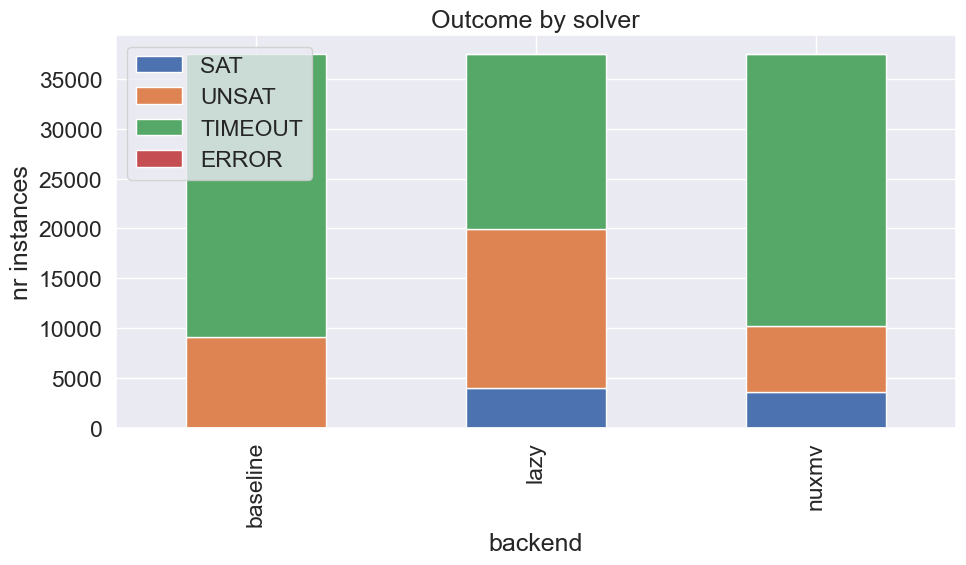

In [16]:
fig, ax = plt.subplots()
runtime_by_status = runtimes.groupby(['backend', 'status']).size().reset_index()
runtime_by_status = runtime_by_status[runtime_by_status[0] > 0]
runtime_by_status.rename(columns = {0: 'count'}, inplace = True)
runtime_by_status = runtime_by_status.set_index(['backend', 'status'])
runtime_by_status.unstack().plot.bar(figsize=(10,6), 
                                     stacked=True, 
                                     ylabel="nr instances",
                                     title="Outcome by solver", ax=ax)
ax.legend([str(heading).replace("Status.", "") for _, heading in runtime_by_status.unstack().columns])
plt.tight_layout()
plt.savefig(f'{commit}-by-solver.pdf', dpi=300)

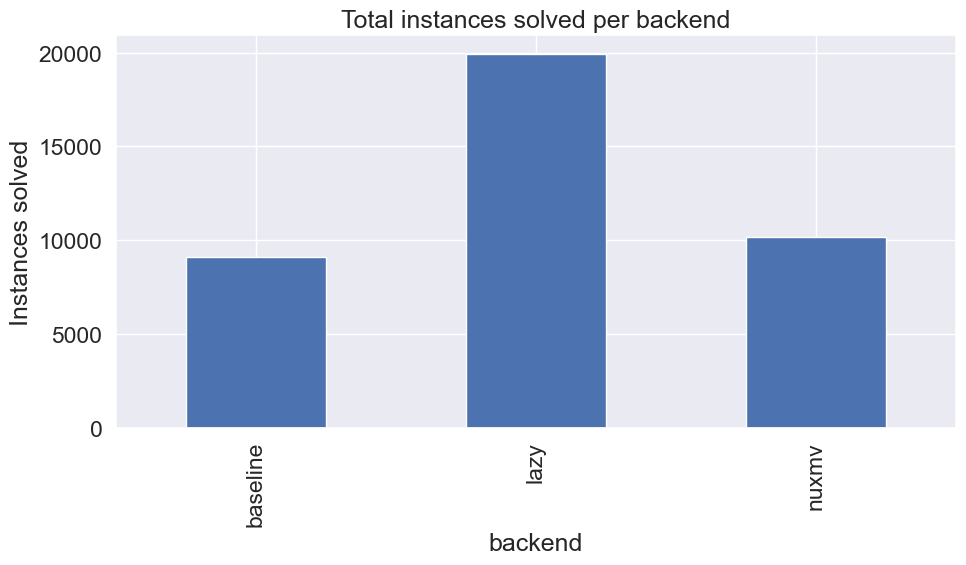

In [17]:
nr_solved = runtimes.groupby(['backend', 'status']).size().reset_index()
nr_solved = nr_solved.loc[nr_solved.status.apply(lambda s: s in [Status.SAT, Status.UNSAT])]
nr_solved.groupby('backend').sum(numeric_only=True).plot.bar(legend=False,
                                            figsize=(10,6),
                                            ylabel="Instances solved",
                                            title="Total instances solved per backend")
plt.tight_layout()

How do the respective solvers do on each type of instance?

In [18]:
by_sat_status = pd.DataFrame(runtimes.groupby('instance').status.min())
by_sat_status['kind'] = by_sat_status['status'].astype("category")
by_sat_status['kind'] = by_sat_status.kind.cat.set_categories([Status.SAT, Status.UNSAT])
del(by_sat_status['status'])

known_solved_with_kind = runtimes[runtimes['status'] < Status.TIMEOUT]\
    .join(by_sat_status, on='instance')

In [19]:
tbl = pd.pivot_table(known_solved_with_kind, values=['runtime'], 
               index=['kind'], columns=['backend'],
               aggfunc='count')['runtime']
tbl.style.to_latex("solved_pivot_table.tex", hrules=True)
tbl

backend,baseline,lazy,nuxmv
kind,,,
Status.SAT,8,3979,3555
Status.UNSAT,9114,15950,6618


## Execution time
For solved instances, for each backend plot the distribution of runtimes

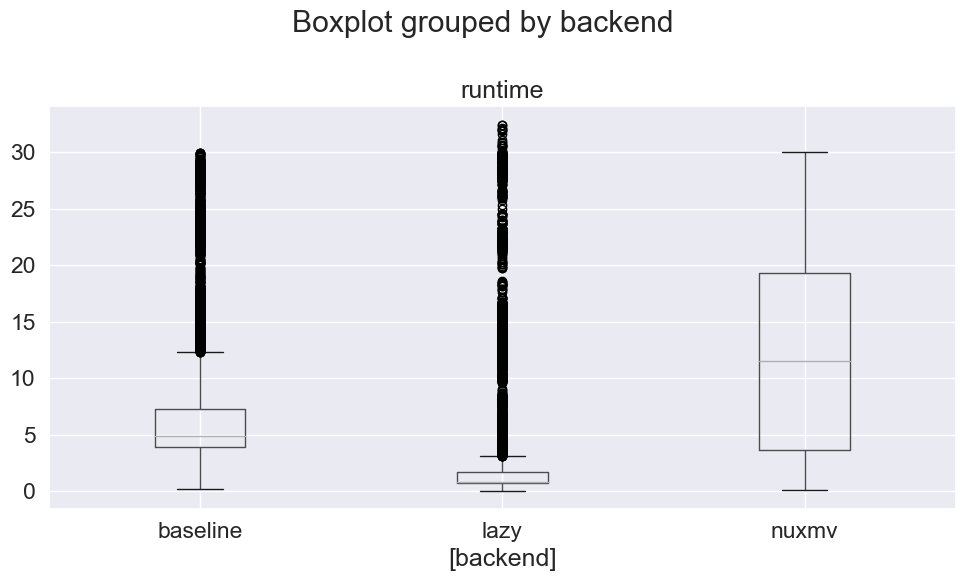

In [20]:
runtimes[runtimes['status'] < Status.TIMEOUT].boxplot(by='backend', figsize=(10,6))
plt.tight_layout()
plt.savefig(f'{commit}-time-boxplot.pdf', dpi=300)

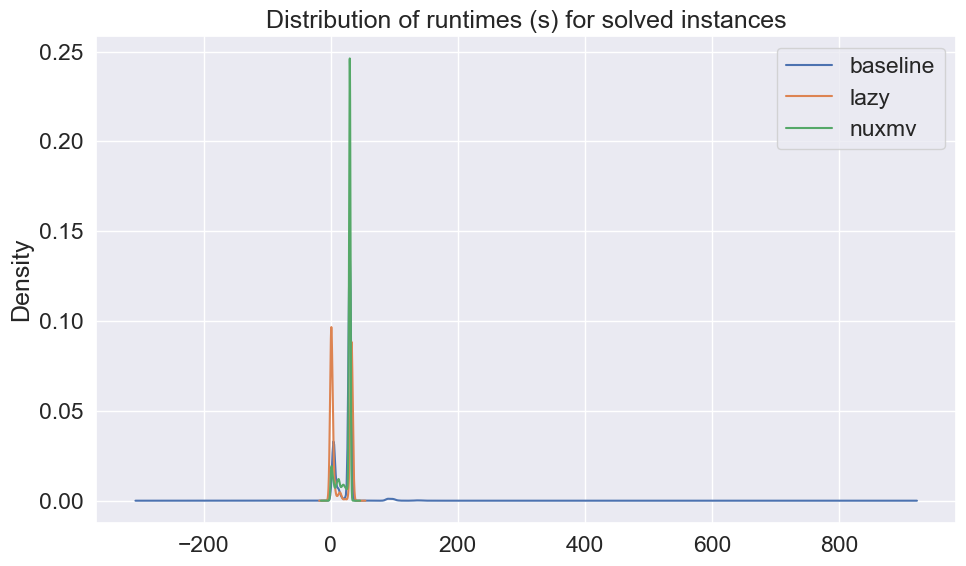

In [21]:
runtimes[runtimes['runtime'] < float('inf')]\
    .set_index('instance')\
    .groupby('backend')\
    .runtime\
    .plot.kde(xlabel='Runtime (s)',
              legend=True,
              figsize=(10, 6),
              title='Distribution of runtimes (s) for solved instances')
plt.tight_layout()

## Scalability (this is the cactus plot section)
If we add more time, how many more instances can we solve?

In [46]:
cactus_runtimes = pd.concat([
    experiments.parse_catra_log("results-120/catra-0.1.4-5.experiments.all_baseline.log", "baseline").drop_duplicates("instance", keep="last"),
    experiments.parse_catra_log("results-120/catra-0.1.4-5.experiments.all_lazy.log", "lazy"),
    experiments.parse_catra_log("results-120/catra-0.1.4-5.experiments.all_lazy_no_learning.log", "lazy, no learning"),
    experiments.parse_catra_log("results-120/catra-0.1.4-5.experiments.all_lazy_no_learning_no_restarts.log", "lazy, no learning, no restarts"),
    experiments.parse_catra_log("results-120/catra-0.1.4-5.experiments.all_nuxmv.log", "nuxmv")
])
# This is because apparently Pandas loses the categoricity when concatenating, and apparently 
# that breaks plotting with the least useful error messages you can imagine. Pandas is bad.
cactus_runtimes['backend'] = cactus_runtimes['backend'].astype("category") 

Note that we deduplicate the results from baseline. This is because this back-end has so high memory use it cannot be reliably executed repeatedly on the same JVM. Instead, we use ulimit and GNU Timeout to limit its execution time and run each instance only twice, keeping only the second, warm, result. This is technically cheating, since the values we use are from a JVM that is warm with respect to the input we are running, but since we are cheating for our *baseline*, we felt this was admissable.

In [47]:
nr_total, cactus_data = experiments.prepare_cactus_plot(cactus_runtimes, timeout_s=120, step_size=1)

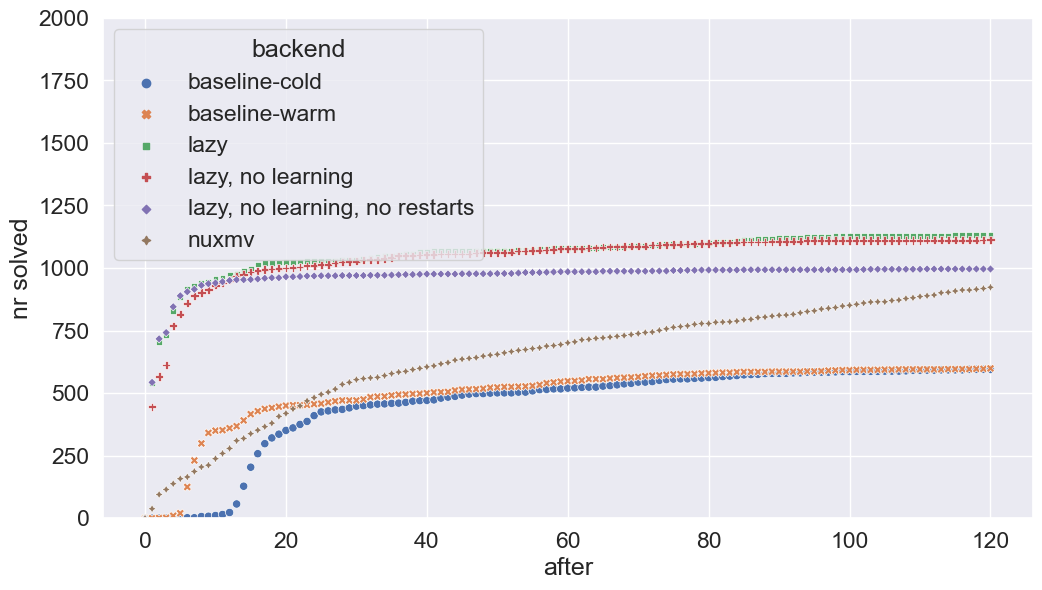

In [48]:
fig, ax = plt.subplots(figsize=(12,6.5))

p = sns.scatterplot(data=cactus_data, 
                    x='after', 
                    y='nr solved', 
                    hue='backend', 
                    style='backend', 
                    ax=ax)

ax.set_ylim(0, nr_total)

#sns.move_legend(p, bbox_to_anchor=(1, 1.02), loc='upper left')
plt.savefig(f'{commit}-cactus.pdf', dpi=300)

## Duels

This is where we compare pairs of backends. In order to make timeouts plottable we set the runtime of an instance that timed out to the timeout value, as opposed to positive infinity.

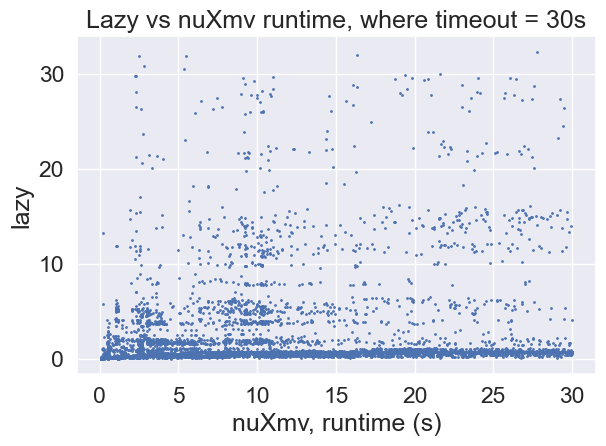

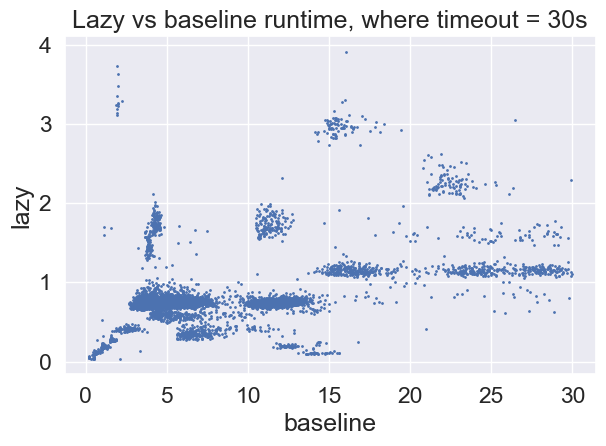

In [25]:
runtimes_by_backend = runtimes[runtimes['status'] < Status.TIMEOUT].set_index(['instance', 'backend']).runtime\
    .unstack()\
    .replace(to_replace=float('inf'), value=TIMEOUT_S)
runtimes_by_backend.plot.scatter(x='nuxmv', y='lazy', 
                                 title=f"Lazy vs nuXmv runtime, where timeout = {TIMEOUT_S}s", 
                                 s=1, 
                                 xlabel="nuXmv, runtime (s)")
plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-nuxmv-scatter.pdf', dpi=300)


runtimes_by_backend.plot.scatter(x='baseline', y='lazy', 
                                 title=f"Lazy vs baseline runtime, where timeout = {TIMEOUT_S}s", 
                                 s=1)

plt.tight_layout()
plt.savefig(f'{commit}-duels-lazy-baseline-scatter.pdf', dpi=300)

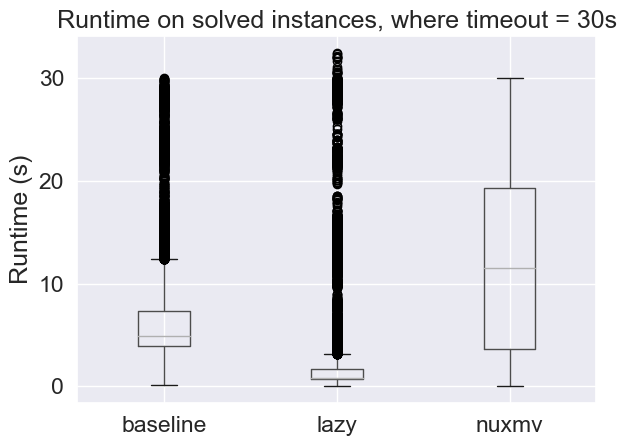

In [26]:
fig = runtimes_by_backend.boxplot()
fig.set_ylabel("Runtime (s)")
fig.set_title(f"Runtime on solved instances, where timeout = {TIMEOUT_S}s")
plt.tight_layout()

## Winners

In [73]:
winners = success_runs.loc[success_runs.groupby('instance').runtime.idxmin()]

In [80]:
winners.groupby("backend").instance.count()

backend
baseline      122
lazy        18880
nuxmv        2631
Name: instance, dtype: int64

In [86]:
#winners[winners["backend"] == "lazy"].instance.to_csv("won_instances.csv")